In [ ]:
!pip install cgmquantify

In [ ]:
!pip install imbalanced-learn


In [1]:
import cgmquantify as cgm
import pandas as pd
import datetime as datetime
from datetime import date
from scipy.stats import stats
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from scipy.signal import find_peaks
from scipy.stats import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd


## Read dataframe with labeled by patient_reported_outcome

In [79]:
df_merged_all = pd.read_csv('df_overnight_and_PRO.csv', sep='\t')

In [80]:
df_merged_all.label.value_counts()

non-fasting    45200
Undefined      44973
fasting        22805
None               1
Name: label, dtype: int64

In [81]:
df_merged_all = df_merged_all.dropna(subset=['axis1', 'axis2', 'axis3'],how='all')

df_merged_all['axis1'] = df_merged_all['axis1'].fillna(0)
df_merged_all['axis2'] = df_merged_all['axis2'].fillna(0)
df_merged_all['axis3'] = df_merged_all['axis3'].fillna(0)

df_merged_all['time'] = pd.to_datetime(df_merged_all['time'] ,errors = 'coerce')

df_merged_all = df_merged_all.reset_index(drop=True)
df_merged_all = df_merged_all.drop(["Unnamed: 0", "joinID"], axis=1)

fasting_states_to_keep = ['fasting', 'non-fasting']
df_merged_all = df_merged_all[df_merged_all.label.isin(fasting_states_to_keep)]


final_df = df_merged_all.sort_values(by=['id', 'time'], ascending=True)

In [83]:
final_df['Time'] = pd.to_datetime(final_df['time'], format='%Y-%m-%dT%H:%M:%S')
final_df['Glucose'] = pd.to_numeric(final_df['gl'])
final_df['Day'] = final_df["Time"].dt.date
final_df = final_df.reset_index(drop=True)

## Split to windowed data

In [85]:
x_list_train = []
train_labels = []


window_size = 3
step_size = 1

# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    time = df_train['Time'].values[i: i + window_size]
    times = df_train['Day'].values[i: i + window_size]
    gls = df_train['Glucose'].values[i: i + window_size]
    steps = df_train['steps'].values[i: i + window_size]
    inclineStanding = df_train['inclineStanding'].values[i: i + window_size]
    inclineSitting = df_train['inclineSitting'].values[i: i + window_size]
    inclineLying = df_train['inclineLying'].values[i: i + window_size]
    
    timedelta_first = time[1] - time[0]
    timedelta_second = time[2] - time[1]
    one_hour = 3600000000000
    
    if (timedelta_first < one_hour and timedelta_second < one_hour):
   
    
        xs = df_train['axis1'].values[i: i + window_size]
        ys = df_train['axis2'].values[i: i + window_size]
        zs = df_train['axis3'].values[i: i + window_size]

        label = stats.mode(df_train['label'][i: i + window_size])[0][0]

        df_slice = pd.DataFrame(time, columns=['Time'])
        df_slice["Day"] = times
        df_slice["Glucose"] = gls   
        df_slice["axis1"] = xs
        df_slice["axis2"] = ys
        df_slice["axis3"] = zs
        df_slice["steps"] = steps
        df_slice["inclineStanding"] = inclineStanding
        df_slice["inclineSitting"] = inclineSitting
        df_slice["inclineLying"] = inclineLying

        x_list_train.append(df_slice)

        train_labels.append(label)

In [87]:
x_list_test = []
test_labels = []


window_size = 3
step_size = 1

# creating overlaping windows of size window-size 100
for i in range(0, df_test.shape[0] - window_size, step_size):
    time = df_test['Time'].values[i: i + window_size]
    times = df_test['Day'].values[i: i + window_size]
    gls = df_test['Glucose'].values[i: i + window_size]
    steps = df_test['steps'].values[i: i + window_size]
    inclineStanding = df_test['inclineStanding'].values[i: i + window_size]
    inclineSitting = df_test['inclineSitting'].values[i: i + window_size]
    inclineLying = df_test['inclineLying'].values[i: i + window_size]
    
    timedelta_first = time[1] - time[0]
    timedelta_second = time[2] - time[1]
    one_hour = 3600000000000
    
    if (timedelta_first < one_hour and timedelta_second < one_hour):
    
        xs = df_test['axis1'].values[i: i + window_size]
        ys = df_test['axis2'].values[i: i + window_size]
        zs = df_test['axis3'].values[i: i + window_size]

        label = stats.mode(df_test['label'][i: i + window_size])[0][0]

        df_slice = pd.DataFrame(time, columns=['Time'])
        df_slice["Day"] = times
        df_slice["Glucose"] = gls     
        df_slice["axis1"] = xs
        df_slice["axis2"] = ys
        df_slice["axis3"] = zs
        df_slice["steps"] = steps
        df_slice["inclineStanding"] = inclineStanding
        df_slice["inclineSitting"] = inclineSitting
        df_slice["inclineLying"] = inclineLying

        x_list_test.append(df_slice)

        test_labels.append(label)

## Feature computation

In [40]:
def feat_statistical_measures_gl_acc(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        cgm_summary = list(cgm.summary(df_temp))
        cgm_LBGI = cgm.LBGI(df_temp)
        cgm_HBGI = cgm.HBGI(df_temp)
        cgm_ADRR = cgm.ADRR(df_temp)
        cgm_GMI = cgm.GMI(df_temp)
        cgm_J_index = cgm.J_index(df_temp)
        cgm_eA1c = cgm.eA1c(df_temp)
        cgm_interdaysd = cgm.interdaysd(df_temp)
        cgm_interdaycv = cgm.interdaycv(df_temp)
        cgm_TOR = cgm.TOR(df_temp, sd=1, sr=15)
        cgm_TIR = cgm.TIR(df_temp, sd=1, sr=15)
        cgm_POR = cgm.POR(df_temp, sd=1, sr=15)
        cgm_MAGN = cgm.MAGN(df_temp, sd=1)
        cgm_MAGE = cgm.MAGE(df_temp, sd=1)  
        
        cgm_summary.append(cgm_LBGI)
        cgm_summary.append(cgm_HBGI)
        cgm_summary.append(cgm_ADRR)
        cgm_summary.append(cgm_GMI)
        cgm_summary.append(cgm_J_index)
        cgm_summary.append(cgm_eA1c)
        cgm_summary.append(cgm_interdaysd)
        cgm_summary.append(cgm_interdaycv)

        cgm_summary.append(cgm_TOR)
        cgm_summary.append(cgm_TIR)
        cgm_summary.append(cgm_POR)
        
        
        # mean
        x_mean = df_temp["axis1"].mean()
        y_mean = df_temp["axis2"].mean()
        z_mean = df_temp["axis3"].mean()

        # std dev
        x_std = df_temp["axis1"].std()
        y_std = df_temp["axis2"].std()
        z_std = df_temp["axis3"].std()
        
        
        # avg absolute diff
        x_aad = (df_temp["axis1"] - df_temp["axis1"].mean()).abs().mean()
        y_aad = (df_temp["axis2"] - df_temp["axis2"].mean()).abs().mean()
        z_aad = (df_temp["axis3"] - df_temp["axis3"].mean()).abs().mean()

                                                 
        # min
        x_min = df_temp["axis1"].min()
        y_min = df_temp["axis2"].min()
        z_min = df_temp["axis3"].min()

        # max
        x_max = df_temp["axis1"].max()
        y_max = df_temp["axis2"].max()
        z_max = df_temp["axis3"].max()

        # max-min diff
        x_maxmin_diff = x_max - x_min
        y_maxmin_diff = y_max - y_min
        z_maxmin_diff = z_max - z_min

        # median
        x_median = df_temp["axis1"].median()
        y_median = df_temp["axis2"].median()
        z_median = df_temp["axis3"].median()
        steps = df_temp["steps"].median()
        inclineStanding = df_temp["inclineStanding"].median()
        inclineSitting = df_temp["inclineSitting"].median()
        inclineLying = df_temp["inclineLying"].median()
        
        # median abs dev
        x_mad = (df_temp["axis1"] - df_temp["axis1"].median()).abs().median()
        y_mad = (df_temp["axis2"] - df_temp["axis2"].median()).abs().median()
        z_mad = (df_temp["axis3"] - df_temp["axis3"].median()).abs().median()

        # interquartile range
        x_IQR = (df_temp["axis1"].quantile(0.75) - df_temp["axis1"].quantile(0.25))
        y_IQR = (df_temp["axis2"].quantile(0.75) - df_temp["axis2"].quantile(0.25))
        z_IQR = (df_temp["axis3"].quantile(0.75) - df_temp["axis3"].quantile(0.25))

        # negtive count
        x_neg_count = (df_temp["axis1"] < 0).sum().sum()
        y_neg_count = (df_temp["axis2"] < 0).sum().sum()
        z_neg_count = (df_temp["axis3"] < 0).sum().sum()

        # positive count
        x_pos_count = (df_temp["axis1"] > 0).sum().sum()
        y_pos_count = (df_temp["axis2"] > 0).sum().sum()
        z_pos_count = (df_temp["axis3"] > 0).sum().sum()

        # values above mean
        x_above_mean = (df_temp["axis1"] > df_temp["axis1"].mean()).sum().sum()
        y_above_mean = (df_temp["axis2"] > df_temp["axis2"].mean()).sum().sum()
        z_above_mean = (df_temp["axis3"] > df_temp["axis3"].mean()).sum().sum()

        # number of peaks
        x_peak_count = len(find_peaks(df_temp["axis1"])[0])
        y_peak_count = len(find_peaks(df_temp["axis2"])[0])
        z_peak_count = len(find_peaks(df_temp["axis3"])[0])

        # skewness
        x_skewness = stats.skew(df_temp["axis1"])
        y_skewness = stats.skew(df_temp["axis2"])
        z_skewness = stats.skew(df_temp["axis3"])

        # kurtosis
        x_kurtosis = stats.kurtosis(df_temp["axis1"])
        y_kurtosis = stats.kurtosis(df_temp["axis2"])
        z_kurtosis = stats.kurtosis(df_temp["axis3"])

        # energy
        x_energy = ((df_temp["axis1"] **2) / 100).sum()
        y_energy = ((df_temp["axis2"] **2) / 100).sum()
        z_energy = ((df_temp["axis3"] **2) / 100).sum()

        # avg resultant
        avg_result_accl = ((df_temp["axis1"] ** 2 + df_temp["axis2"] ** 2 + df_temp["axis3"] ** 2) ** 0.5).mean()

        # signal magnitude area
        sma = (df_temp["axis1"].abs() / 100).sum() +(df_temp["axis2"].abs() / 100).sum() + (df_temp["axis3"].abs() / 100).sum()
        
        


        acc_summary = []
        acc_summary.extend([x_mean , y_mean, z_mean, x_std, y_std, z_std, x_aad, y_aad, z_aad, x_min, y_min, z_min, x_max, y_max, z_max, 
                            x_maxmin_diff, y_maxmin_diff, z_maxmin_diff, x_median, y_median, z_median, x_mad, y_mad, z_mad, x_IQR, y_IQR, z_IQR,
                            x_neg_count, y_neg_count, z_neg_count, x_pos_count, y_pos_count, z_pos_count,x_above_mean, y_above_mean, z_above_mean,
                            x_peak_count, y_peak_count, z_peak_count, x_skewness, y_skewness, z_skewness, x_kurtosis, y_kurtosis, z_kurtosis, x_energy,
                            y_energy, z_energy, avg_result_accl, sma, steps, inclineStanding, inclineSitting, inclineLying])
        

        features = cgm_summary
        features.extend(acc_summary)

        X_train_temp = pd.DataFrame([features], columns = ["mean", "median","minimum", "maximum","first_quartile", "third_quartile",
                                                              "LBGI", "HBGI", "ADRR","GMI", "J_index", "eA1c", "interdaysd",
                                                              "cgm_interdaycv", 
                                                              "cgm_TOR", "cgm_TIR",
                                                              "cgm_POR",
                                                              "x_mean" , "y_mean", "z_mean", "x_std", "y_std", "z_std", "x_aad", "y_aad", "z_aad", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max", 
                                                              "x_maxmin_diff", "y_maxmin_diff", "z_maxmin_diff", "x_median", "y_median", "z_median", "x_mad", "y_mad", "z_mad", "x_IQR", "y_IQR", "z_IQR",
                                                              "x_neg_count", "y_neg_count", "z_neg_count", "x_pos_count", "y_pos_count", "z_pos_count","x_above_mean", "y_above_mean", "z_above_mean",
                                                              "x_peak_count", "y_peak_count", "z_peak_count", "x_skewness", "y_skewness", "z_skewness", "x_kurtosis", "y_kurtosis", "z_kurtosis", "x_energy",
                                                              "y_energy", "z_energy", "avg_result_accl", "sma", "steps", "inclineStanding", "inclineSitting", "inclineLying"])

        
        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)
        
    return X_train

In [41]:
def feat_statistical_measures_gl(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        cgm_summary = list(cgm.summary(df_temp))
        cgm_LBGI = cgm.LBGI(df_temp)
        cgm_HBGI = cgm.HBGI(df_temp)
        cgm_ADRR = cgm.ADRR(df_temp)
        cgm_GMI = cgm.GMI(df_temp)
        cgm_J_index = cgm.J_index(df_temp)
        cgm_eA1c = cgm.eA1c(df_temp)
        cgm_interdaysd = cgm.interdaysd(df_temp)
        cgm_interdaycv = cgm.interdaycv(df_temp)
        cgm_TOR = cgm.TOR(df_temp, sd=1, sr=15)
        cgm_TIR = cgm.TIR(df_temp, sd=1, sr=15)
        cgm_POR = cgm.POR(df_temp, sd=1, sr=15)

        
        cgm_summary.append(cgm_LBGI)
        cgm_summary.append(cgm_HBGI)
        cgm_summary.append(cgm_ADRR)
        cgm_summary.append(cgm_GMI)
        cgm_summary.append(cgm_J_index)
        cgm_summary.append(cgm_eA1c)
        cgm_summary.append(cgm_interdaysd)
        cgm_summary.append(cgm_interdaycv)
        cgm_summary.append(cgm_TOR)
        cgm_summary.append(cgm_TIR)
        cgm_summary.append(cgm_POR)


        features = cgm_summary

        X_train_temp = pd.DataFrame([cgm_summary], columns = ["mean", "median","minimum", "maximum","first_quartile", "third_quartile",
                                                              "LBGI", "HBGI", "ADRR","GMI", "J_index", "eA1c", "interdaysd",
                                                              "cgm_interdaycv", 
                                                              "cgm_TOR", "cgm_TIR",
                                                              "cgm_POR"])

        
        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)
        
    return X_train

In [42]:
def feat_statistical_measures_acc(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:

        # mean
        x_mean = df_temp["axis1"].mean()
        y_mean = df_temp["axis2"].mean()
        z_mean = df_temp["axis3"].mean()

        # std dev
        x_std = df_temp["axis1"].std()
        y_std = df_temp["axis2"].std()
        z_std = df_temp["axis3"].std()
        
        
        # avg absolute diff
        x_aad = (df_temp["axis1"] - df_temp["axis1"].mean()).abs().mean()
        y_aad = (df_temp["axis2"] - df_temp["axis2"].mean()).abs().mean()
        z_aad = (df_temp["axis3"] - df_temp["axis3"].mean()).abs().mean()

                                                 
        # min
        x_min = df_temp["axis1"].min()
        y_min = df_temp["axis2"].min()
        z_min = df_temp["axis3"].min()

        # max
        x_max = df_temp["axis1"].max()
        y_max = df_temp["axis2"].max()
        z_max = df_temp["axis3"].max()

        # max-min diff
        x_maxmin_diff = x_max - x_min
        y_maxmin_diff = y_max - y_min
        z_maxmin_diff = z_max - z_min

        # median
        x_median = df_temp["axis1"].median()
        y_median = df_temp["axis2"].median()
        z_median = df_temp["axis3"].median()
        steps = df_temp["steps"].median()
        inclineStanding = df_temp["inclineStanding"].median()
        inclineSitting = df_temp["inclineSitting"].median()
        inclineLying = df_temp["inclineLying"].median()
        
        # median abs dev
        x_mad = (df_temp["axis1"] - df_temp["axis1"].median()).abs().median()
        y_mad = (df_temp["axis2"] - df_temp["axis2"].median()).abs().median()
        z_mad = (df_temp["axis3"] - df_temp["axis3"].median()).abs().median()

        # interquartile range
        x_IQR = (df_temp["axis1"].quantile(0.75) - df_temp["axis1"].quantile(0.25))
        y_IQR = (df_temp["axis2"].quantile(0.75) - df_temp["axis2"].quantile(0.25))
        z_IQR = (df_temp["axis3"].quantile(0.75) - df_temp["axis3"].quantile(0.25))

        # negtive count
        x_neg_count = (df_temp["axis1"] < 0).sum().sum()
        y_neg_count = (df_temp["axis2"] < 0).sum().sum()
        z_neg_count = (df_temp["axis3"] < 0).sum().sum()

        # positive count
        x_pos_count = (df_temp["axis1"] > 0).sum().sum()
        y_pos_count = (df_temp["axis2"] > 0).sum().sum()
        z_pos_count = (df_temp["axis3"] > 0).sum().sum()

        # values above mean
        x_above_mean = (df_temp["axis1"] > df_temp["axis1"].mean()).sum().sum()
        y_above_mean = (df_temp["axis2"] > df_temp["axis2"].mean()).sum().sum()
        z_above_mean = (df_temp["axis3"] > df_temp["axis3"].mean()).sum().sum()

        # number of peaks
        x_peak_count = len(find_peaks(df_temp["axis1"])[0])
        y_peak_count = len(find_peaks(df_temp["axis2"])[0])
        z_peak_count = len(find_peaks(df_temp["axis3"])[0])

        # skewness
        x_skewness = stats.skew(df_temp["axis1"])
        y_skewness = stats.skew(df_temp["axis2"])
        z_skewness = stats.skew(df_temp["axis3"])

        # kurtosis
        x_kurtosis = stats.kurtosis(df_temp["axis1"])
        y_kurtosis = stats.kurtosis(df_temp["axis2"])
        z_kurtosis = stats.kurtosis(df_temp["axis3"])

        # energy
        x_energy = ((df_temp["axis1"] **2) / 100).sum()
        y_energy = ((df_temp["axis2"] **2) / 100).sum()
        z_energy = ((df_temp["axis3"] **2) / 100).sum()

        # avg resultant
        avg_result_accl = ((df_temp["axis1"] ** 2 + df_temp["axis2"] ** 2 + df_temp["axis3"] ** 2) ** 0.5).mean()

        # signal magnitude area
        sma = (df_temp["axis1"].abs() / 100).sum() +(df_temp["axis2"].abs() / 100).sum() + (df_temp["axis3"].abs() / 100).sum()
        
        


        acc_summary = []
        acc_summary.extend([x_mean , y_mean, z_mean, x_std, y_std, z_std, x_aad, y_aad, z_aad, x_min, y_min, z_min, x_max, y_max, z_max, 
                            x_maxmin_diff, y_maxmin_diff, z_maxmin_diff, x_median, y_median, z_median, x_mad, y_mad, z_mad, x_IQR, y_IQR, z_IQR,
                            x_neg_count, y_neg_count, z_neg_count, x_pos_count, y_pos_count, z_pos_count,x_above_mean, y_above_mean, z_above_mean,
                            x_peak_count, y_peak_count, z_peak_count, x_skewness, y_skewness, z_skewness, x_kurtosis, y_kurtosis, z_kurtosis, x_energy,
                            y_energy, z_energy, avg_result_accl, sma, steps, inclineStanding, inclineSitting, inclineLying])
        


        X_train_temp = pd.DataFrame([acc_summary], columns = ["x_mean" , "y_mean", "z_mean", "x_std", "y_std", "z_std", "x_aad", "y_aad", "z_aad", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max", 
                                                              "x_maxmin_diff", "y_maxmin_diff", "z_maxmin_diff", "x_median", "y_median", "z_median", "x_mad", "y_mad", "z_mad", "x_IQR", "y_IQR", "z_IQR",
                                                              "x_neg_count", "y_neg_count", "z_neg_count", "x_pos_count", "y_pos_count", "z_pos_count","x_above_mean", "y_above_mean", "z_above_mean",
                                                              "x_peak_count", "y_peak_count", "z_peak_count", "x_skewness", "y_skewness", "z_skewness", "x_kurtosis", "y_kurtosis", "z_kurtosis", "x_energy",
                                                              "y_energy", "z_energy", "avg_result_accl", "sma", "steps", "inclineStanding", "inclineSitting", "inclineLying"])

        
        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)
        
    return X_train

In [43]:
def feat_statistical_measures_gl_acc_ml(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        cgm_summary = list(cgm.summary(df_temp))
        cgm_J_index = cgm.J_index(df_temp)
        cgm_interdaycv = cgm.interdaycv(df_temp)

        cgm_summary.append(cgm_J_index)
        cgm_summary.append(cgm_interdaycv)


        z_mean = df_temp["axis3"].mean()
        y_max = df_temp["axis2"].max()
        z_energy = ((df_temp["axis3"] ** 2) / 100).sum()

        acc_summary = []
        acc_summary.extend(
            [z_mean, y_max, z_energy])

        features = cgm_summary
        features.extend(acc_summary)

        X_train_temp = pd.DataFrame([features],
                                    columns=["mean", "median", "minimum", "maximum", "first_quartile", "third_quartile",
                                             "J_index", "cgm_interdaycv", "z_mean", "y_max", "z_energy"])

        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)

    return X_train

In [44]:
def feat_statistical_measures_acc_ml(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        # mean
        z_mean = df_temp["axis3"].mean()
        y_max = df_temp["axis2"].max()
        z_energy = ((df_temp["axis3"] ** 2) / 100).sum()


        acc_summary = []
        acc_summary.extend(
            [z_mean, y_max, z_energy])

        X_train_temp = pd.DataFrame([acc_summary],
                                    columns=["z_mean", "y_max", "z_energy"])

        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)

    return X_train


In [45]:
def feat_statistical_measures_gl_ml(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        cgm_summary = list(cgm.summary(df_temp))
        cgm_LBGI = cgm.LBGI(df_temp)
        cgm_HBGI = cgm.HBGI(df_temp)
        cgm_ADRR = cgm.ADRR(df_temp)
        cgm_GMI = cgm.GMI(df_temp)
        cgm_J_index = cgm.J_index(df_temp)
        cgm_eA1c = cgm.eA1c(df_temp)
        cgm_interdaysd = cgm.interdaysd(df_temp)
        cgm_interdaycv = cgm.interdaycv(df_temp)
        cgm_TOR = cgm.TOR(df_temp, sd=1, sr=15)
        cgm_TIR = cgm.TIR(df_temp, sd=1, sr=15)
        cgm_POR = cgm.POR(df_temp, sd=1, sr=15)


        cgm_summary.append(cgm_LBGI)
        cgm_summary.append(cgm_HBGI)
        cgm_summary.append(cgm_ADRR)
        cgm_summary.append(cgm_GMI)
        cgm_summary.append(cgm_J_index)
        cgm_summary.append(cgm_eA1c)
        cgm_summary.append(cgm_interdaysd)
        cgm_summary.append(cgm_interdaycv)
        cgm_summary.append(cgm_TOR)
        cgm_summary.append(cgm_TIR)
        cgm_summary.append(cgm_POR)

        X_train_temp = pd.DataFrame([cgm_summary],
                                    columns=["mean", "median", "minimum", "maximum", "first_quartile", "third_quartile",
                                             "LBGI", "HBGI", "ADRR", "GMI", "J_index", "eA1c", "interdaysd",
                                             "cgm_interdaycv",
                                             "cgm_TOR", "cgm_TIR",
                                             "cgm_POR"])

        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)

    return X_train

In [83]:

X_test = feat_statistical_measures_gl_acc(x_list_test)

X_train = feat_statistical_measures_gl_acc(x_list_train)

In [46]:

X_test = feat_statistical_measures_gl_ml( x_list_test)

X_train = feat_statistical_measures_gl_ml(x_list_train)

In [18]:

X_test = feat_statistical_measures_gl_acc_ml( x_list_test)

X_train = feat_statistical_measures_gl_acc_ml(x_list_train)

In [88]:

X_test = feat_statistical_measures_acc_ml( x_list_test)

X_train = feat_statistical_measures_acc_ml(x_list_train)

In [20]:
X_test

,mean,median,minimum,maximum,first_quartile,third_quartile,J_index,cgm_interdaycv,z_mean,y_max,z_energy
0,87.666667,88.0,84.0,91.0,86.0,89.5,8.196425,3.270846,483.000000,1129.0,8388.17
1,90.666667,87.0,83.0,102.0,85.0,94.5,9.770379,9.020474,347.000000,486.0,5418.65
2,75.666667,83.0,42.0,102.0,62.5,92.5,10.141379,33.089536,231.666667,486.0,2989.73
3,86.666667,97.0,57.0,106.0,77.0,101.5,11.656120,24.573281,337.333333,290.0,6908.74
4,99.666667,97.0,96.0,106.0,96.5,101.5,10.850051,4.511952,330.000000,290.0,6822.50
...,...,...,...,...,...,...,...,...,...,...,...
7360,86.333333,86.0,83.0,90.0,84.5,88.0,7.956778,3.321361,248.666667,590.0,4218.04
7361,86.333333,86.0,83.0,90.0,84.5,88.0,7.956778,3.321361,356.666667,693.0,5902.84
7362,88.333333,89.0,86.0,90.0,87.5,89.5,8.105942,1.924158,468.666667,1026.0,7072.12
7363,89.000000,88.0,88.0,91.0,88.0,89.5,8.174730,1.589004,256.000000,615.0,3666.86


In [89]:
X_test.to_csv("ML_data/eval_X_test_acc.csv", sep='\t')
X_train.to_csv("ML_data/eval_X_train_acc.csv", sep='\t')


In [90]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [91]:
def to_float(input_string):
    if input_string == "fasting":
        return 0
    else:
        return 1

In [92]:
func_float = np.vectorize(to_float)
y_train_float = func_float(y_train)
y_test_float = func_float(y_test)

In [93]:
np.save('ML_data/y_train_eval_acc.npy', y_train_float)
np.save('ML_data/y_test_eval_acc.npy', y_test_float)

In [142]:
features_to_keep = ["cgm_interdaycv", "J_index", "maximum", "z_mean", "y_max", "z_energy"]

X_test = X_test[features_to_keep] 
X_train = X_train[features_to_keep] 

In [156]:
features_to_keep = ["cgm_interdaycv", "J_index", "maximum"]

X_test = X_test[features_to_keep] 
X_train = X_train[features_to_keep] 

In [236]:
features_to_keep = ["z_mean", "y_max", "z_energy"]

X_test = X_test[features_to_keep] 
X_train = X_train[features_to_keep] 

# Feature Selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
fit = rfe.fit(X_train, y_train_float)


In [27]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

rfe = RFE(DecisionTreeClassifier(), n_features_to_select=6)
fit = rfe.fit(X_train, y_train_float)
# report selected features
print('Selected Features:')

Selected Features:


In [28]:
fit.ranking_

array([46, 29, 33,  1, 44, 35, 21, 48, 10, 47,  2, 40,  3, 13, 49, 56, 54,
        5,  7,  1, 32, 36, 37, 43, 20, 34, 22, 12,  9,  1,  1,  6, 25, 41,
       16,  1,  1,  8, 14, 15, 18, 39, 26, 42, 66, 63, 65, 51, 52, 60, 58,
       59, 57, 50, 53, 55, 23, 11, 19, 61, 64, 62, 17, 28, 27, 24, 30,  4,
       45, 31, 38])

In [30]:
names = X_train.columns.values[0:-1]
names

array(['mean', 'median', 'minimum', 'maximum', 'first_quartile',
       'third_quartile', 'LBGI', 'HBGI', 'ADRR', 'GMI', 'J_index', 'eA1c',
       'interdaysd', 'cgm_interdaycv', 'cgm_TOR', 'cgm_TIR', 'cgm_POR',
       'x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'x_aad',
       'y_aad', 'z_aad', 'x_min', 'y_min', 'z_min', 'x_max', 'y_max',
       'z_max', 'x_maxmin_diff', 'y_maxmin_diff', 'z_maxmin_diff',
       'x_median', 'y_median', 'z_median', 'x_mad', 'y_mad', 'z_mad',
       'x_IQR', 'y_IQR', 'z_IQR', 'x_neg_count', 'y_neg_count',
       'z_neg_count', 'x_pos_count', 'y_pos_count', 'z_pos_count',
       'x_above_mean', 'y_above_mean', 'z_above_mean', 'x_peak_count',
       'y_peak_count', 'z_peak_count', 'x_skewness', 'y_skewness',
       'z_skewness', 'x_kurtosis', 'y_kurtosis', 'z_kurtosis', 'x_energy',
       'y_energy', 'z_energy', 'avg_result_accl', 'sma', 'steps',
       'inclineStanding', 'inclineSitting'], dtype=object)

In [34]:
X_train['y_max'].corr(X_train['z_mean'])

0.7850871528229749

## Balancing

https://imbalanced-learn.org/stable/over_sampling.html

In [29]:
balanced_df = final_df.drop(["Time", "time", "Day"], axis=1)

balanced_df.phase = pd.Categorical(balanced_df.phase)
balanced_df['phase'] = balanced_df.phase.cat.codes

balanced_df.label = pd.Categorical(balanced_df.label)
balanced_df['label'] = balanced_df.label.cat.codes


In [140]:
X_test = pd.read_csv('eval_X_test.csv', sep='\t')
X_train = pd.read_csv('eval_X_train.csv', sep='\t')

X_test = X_test.drop(["Unnamed: 0"], axis=1)
X_train = X_train.drop(["Unnamed: 0"], axis=1)

In [141]:
y_train_float = np.load('ML_data/y_train_eval.npy')
y_test_float = np.load('ML_data/y_test_eval.npy')

In [21]:
X_test

,mean,median,minimum,maximum,first_quartile,third_quartile,J_index,cgm_interdaycv,z_mean,y_max,z_energy
0,87.666667,88.0,84.0,91.0,86.0,89.5,8.196425,3.270846,483.000000,1129.0,8388.17
1,90.666667,87.0,83.0,102.0,85.0,94.5,9.770379,9.020474,347.000000,486.0,5418.65
2,75.666667,83.0,42.0,102.0,62.5,92.5,10.141379,33.089536,231.666667,486.0,2989.73
3,86.666667,97.0,57.0,106.0,77.0,101.5,11.656120,24.573281,337.333333,290.0,6908.74
4,99.666667,97.0,96.0,106.0,96.5,101.5,10.850051,4.511952,330.000000,290.0,6822.50
...,...,...,...,...,...,...,...,...,...,...,...
7360,86.333333,86.0,83.0,90.0,84.5,88.0,7.956778,3.321361,248.666667,590.0,4218.04
7361,86.333333,86.0,83.0,90.0,84.5,88.0,7.956778,3.321361,356.666667,693.0,5902.84
7362,88.333333,89.0,86.0,90.0,87.5,89.5,8.105942,1.924158,468.666667,1026.0,7072.12
7363,89.000000,88.0,88.0,91.0,88.0,89.5,8.174730,1.589004,256.000000,615.0,3666.86


In [126]:
print(sorted(collections.Counter(y_test_float).items()))
print(sorted(collections.Counter(y_train_float).items()))

[(0, 1600), (1, 5765)]
[(0, 11734), (1, 36196)]


In [143]:
from imblearn.combine import SMOTETomek
import collections

In [144]:

smote_tomek = SMOTETomek(random_state=0)
X_test_resampled, y_test_resampled = smote_tomek.fit_resample(X_test, y_test_float)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train_float)


In [145]:
print(sorted(collections.Counter(y_test_resampled).items()))
print(sorted(collections.Counter(y_train_resampled).items()))


[(0, 5415), (1, 5415)]
[(0, 34506), (1, 34506)]


In [146]:
X_train_resampled.values

array([[4.82330175e+00, 6.40241948e+00, 8.10000000e+01, 4.14666667e+02,
        1.02800000e+03, 8.81194000e+03],
       [2.95924233e+00, 5.64906271e+00, 7.60000000e+01, 3.82000000e+02,
        1.02800000e+03, 8.39054000e+03],
       [5.86555630e+00, 5.28446833e+00, 7.20000000e+01, 5.40666667e+02,
        1.02800000e+03, 1.14464600e+04],
       ...,
       [1.45293786e+01, 1.00564004e+01, 1.03883244e+02, 2.12943433e+03,
        4.72827269e+03, 2.54651434e+05],
       [1.29961331e+00, 1.14423816e+01, 1.07337880e+02, 8.62950332e+01,
        4.88216159e+02, 6.08527025e+02],
       [2.15661717e+00, 6.43357768e+00, 8.07808275e+01, 3.78011334e+02,
        1.59052752e+03, 6.17370655e+03]])

In [74]:
X_train_resampled

,cgm_interdaycv,J_index,maximum,z_mean,y_max,z_energy
0,4.823302,6.402419,81.000000,414.666667,1028.000000,8811.940000
1,2.959242,5.649063,76.000000,382.000000,1028.000000,8390.540000
2,5.865556,5.284468,72.000000,540.666667,1028.000000,11446.460000
3,14.627360,7.260120,89.000000,407.000000,821.000000,5860.530000
4,16.868556,9.258631,95.000000,392.333333,821.000000,5733.810000
...,...,...,...,...,...,...
69007,1.291059,10.062293,100.059041,443.624844,1258.023193,9825.737906
69008,12.000033,12.464622,115.050212,308.840675,558.700142,3459.710196
69009,14.529379,10.056400,103.883244,2129.434327,4728.272691,254651.433917
69010,1.299613,11.442382,107.337880,86.295033,488.216159,608.527025


## Logistic Regression

In [147]:
scaler = MinMaxScaler()
scaler.fit(X_train_resampled)

X_train_data_lr = pd.DataFrame(scaler.transform(X_train_resampled), index=X_train_resampled.index, columns=X_train_resampled.columns)
X_test_data_lr = pd.DataFrame(scaler.transform(X_test_resampled), index=X_test_resampled.index, columns=X_test_resampled.columns)

In [130]:
scaler = MinMaxScaler()
scaler.fit(X_train_resampled)
X_train_data_lr = scaler.transform(X_train_resampled)
X_test_data_lr = scaler.transform(X_test_resampled)


In [120]:
# logistic regression model
lr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=157, C=0.97)
lr.fit(X_train_data_lr, y_train_resampled)
y_pred = lr.predict(X_test_data_lr)
y_pred = smoothing(y_pred)
print("Accuracy:", accuracy_score(y_test_resampled, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, y_pred))

Accuracy: 0.6644229043259738

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      5571
           1       0.65      0.71      0.68      5571

    accuracy                           0.66     11142
   macro avg       0.67      0.66      0.66     11142
weighted avg       0.67      0.66      0.66     11142



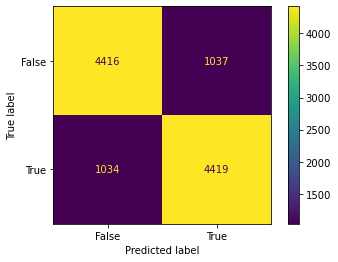

In [37]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

#### Random Search

In [8]:
from sklearn.model_selection import RandomizedSearchCV

In [9]:
estimator = LogisticRegression(
    random_state = 1,
    penalty = 'l2'
)
#estimator.fit(X_train_data_lr, y_train_resampled)

In [10]:
max_iter = range(100, 200)
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C = np.arange(0, 1, 0.01)
random_grid ={
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'C' : C,
}

In [11]:
from sklearn.model_selection import RandomizedSearchCV
random_estimator = RandomizedSearchCV(estimator = estimator,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )

random_estimator.fit(X_train_data_lr, y_train_resampled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=LogisticRegression(random_state=1), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47...
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                                        'max_iter': range(100, 200),
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'liblinear'],
                                        'warm_start': [True, False]},
                   random_state=1, scoring='accuracy', verbose=1)

In [12]:
random_estimator.best_params_

{'warm_start': True, 'solver': 'liblinear', 'max_iter': 157, 'C': 0.97}

In [13]:
random_estimator.best_params_

best_estimator = random_estimator.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(y_test_resampled,pred)

0.7726939299468183

In [17]:
y_pred_smoothed = smoothing(pred)
accuracy_score(y_test_resampled,y_pred_smoothed)

0.8101045296167247

In [45]:
print(metrics.classification_report(y_test_resampled, pred))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      5453
           1       0.75      0.81      0.78      5453

    accuracy                           0.77     10906
   macro avg       0.77      0.77      0.77     10906
weighted avg       0.77      0.77      0.77     10906



#### Evaluation

In [70]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

best parameters: {'warm_start': True, 'solver': 'liblinear', 'max_iter': 157, 'C': 0.97}
best score:      0.80029 (+/-0.01767)
{'C': 0.97,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 157,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': True}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_warm_start,param_solver,param_max_iter,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,0.349796,0.065674,0.003200,0.000401,True,liblinear,157,0.97,"{'warm_start': True, 'solver': 'liblinear', 'm...",0.824166,0.786127,0.777754,0.796665,0.816732,0.800289,0.017675,1
87,0.335999,0.043472,0.003399,0.000489,True,liblinear,132,0.6,"{'warm_start': True, 'solver': 'liblinear', 'm...",0.825321,0.785477,0.776671,0.796088,0.817670,0.800245,0.018566,2
56,0.302397,0.042962,0.003205,0.000398,True,liblinear,107,0.57,"{'warm_start': True, 'solver': 'liblinear', 'm...",0.824960,0.785549,0.776671,0.796304,0.817670,0.800231,0.018448,3
26,0.330598,0.060291,0.005400,0.004800,False,liblinear,140,0.95,"{'warm_start': False, 'solver': 'liblinear', '...",0.824094,0.786127,0.777682,0.796593,0.816659,0.800231,0.017663,3
76,0.350798,0.032442,0.002602,0.000490,True,liblinear,109,0.95,"{'warm_start': True, 'solver': 'liblinear', 'm...",0.824094,0.786127,0.777682,0.796593,0.816659,0.800231,0.017663,3
49,0.300704,0.038529,0.002999,0.000631,False,liblinear,189,0.65,"{'warm_start': False, 'solver': 'liblinear', '...",0.825105,0.785549,0.777393,0.795799,0.817165,0.800202,0.018233,6
38,0.296198,0.052237,0.003200,0.000401,False,liblinear,108,0.65,"{'warm_start': False, 'solver': 'liblinear', '...",0.825105,0.785549,0.777393,0.795799,0.817165,0.800202,0.018233,6
5,0.238201,0.051977,0.001999,0.000632,False,lbfgs,187,0.72,"{'warm_start': False, 'solver': 'lbfgs', 'max_...",0.824599,0.785621,0.777754,0.795871,0.817165,0.800202,0.017990,6
47,0.347519,0.098455,0.003601,0.001743,True,liblinear,178,0.96,"{'warm_start': True, 'solver': 'liblinear', 'm...",0.823950,0.786127,0.777682,0.796593,0.816659,0.800202,0.017624,6
52,0.344014,0.056919,0.002999,0.000001,True,liblinear,126,0.79,"{'warm_start': True, 'solver': 'liblinear', 'm...",0.824311,0.785910,0.777682,0.796376,0.816659,0.800188,0.017766,10


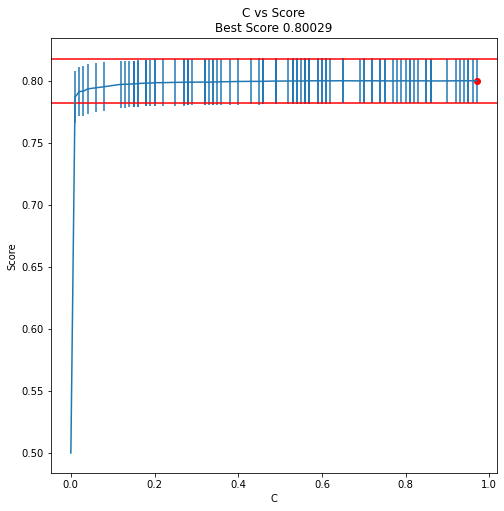

In [46]:
GridSearch_table_plot(random_estimator, "C", negative=False)

In [30]:
random_estimator.cv_results_['params']

[{'warm_start': False, 'solver': 'newton-cg', 'max_iter': 739, 'C': 0.23},
 {'warm_start': False, 'solver': 'lbfgs', 'max_iter': 159, 'C': 0.91},
 {'warm_start': True, 'solver': 'newton-cg', 'max_iter': 287, 'C': 0.87},
 {'warm_start': False, 'solver': 'lbfgs', 'max_iter': 977, 'C': 0.9},
 {'warm_start': False, 'solver': 'newton-cg', 'max_iter': 800, 'C': 0.68},
 {'warm_start': False, 'solver': 'liblinear', 'max_iter': 624, 'C': 0.13},
 {'warm_start': False, 'solver': 'lbfgs', 'max_iter': 797, 'C': 0.21},
 {'warm_start': True, 'solver': 'newton-cg', 'max_iter': 973, 'C': 0.03},
 {'warm_start': True, 'solver': 'newton-cg', 'max_iter': 553, 'C': 0.42},
 {'warm_start': False, 'solver': 'liblinear', 'max_iter': 670, 'C': 0.76},
 {'warm_start': False, 'solver': 'liblinear', 'max_iter': 928, 'C': 0.8},
 {'warm_start': True, 'solver': 'newton-cg', 'max_iter': 395, 'C': 0.54},
 {'warm_start': True, 'solver': 'liblinear', 'max_iter': 983, 'C': 0.3},
 {'warm_start': True,
  'solver': 'lbfgs',
  

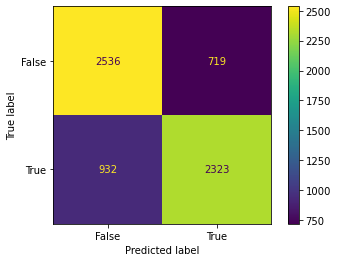

In [239]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [20]:
import pickle
with open('ML_data/models_ML/gl/ML_LR_adapt_scaler.pkl','wb') as f:
    pickle.dump(lr,f)

In [34]:
import pickle
with open('LR_random_estimator.pkl','wb') as f:
    pickle.dump(random_estimator,f)

In [18]:
pickle.dump(scaler, open("ML_data/models_ML/gl/ML_scaler_adapt.pkl", 'wb'))

## SVM

In [99]:
from sklearn import svm

svm_clf = svm.SVC(C=1000.0, kernel='rbf')
svm_clf.fit(X_train_data_lr, y_train_resampled)


SVC(C=1000.0)

In [45]:
y_pred = svm_clf.predict(X_test_data_lr)


In [48]:
print("Accuracy:", accuracy_score(y_test_resampled, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, y_pred))

Accuracy: 0.8366037043829085

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      5453
           1       0.81      0.89      0.84      5453

    accuracy                           0.84     10906
   macro avg       0.84      0.84      0.84     10906
weighted avg       0.84      0.84      0.84     10906



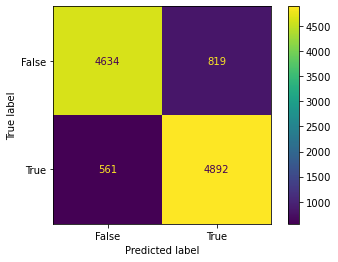

In [47]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [ ]:
import shap
# Fits the explainer
explainer = shap.Explainer(svm_clf.predict, X_test_data_lr)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_data_lr)


Permutation explainer:   1%|▍                                                 | 98/10906 [1:49:01<199:58:15, 66.61s/it]

In [99]:
import pickle
with open('ML_data/models_ML/gl/ML_SVM_adapt.pkl','wb') as f:
    pickle.dump(svm_clf,f)

### Random CV

In [74]:
parameters = {'kernel': ['rbf', 'sigmoid', 'poly'],
             'C': [0.1, 1.0, 100.0, 1000.0],
             'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],}#



In [ ]:
random_estimator = RandomizedSearchCV(estimator = svm_clf,
                                   param_distributions = parameters,
                                   cv = 5,
                                   n_iter = 100,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )

random_estimator.fit(X_train_data_lr, y_train_resampled)

In [ ]:
random_estimator.best_params_

best_estimator = random_estimator.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(pred, y_test_resampled)

In [ ]:
y_pred_smoothed = smoothing(pred)
accuracy_score(y_pred_smoothed, y_test_resampled)

best parameters: {'kernel': 'rbf', 'gamma': 1.0, 'C': 1000.0}
best score:      0.83883 (+/-0.02724)
{'C': 1000.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
69,322.016056,19.344529,44.813872,3.534281,rbf,1.0,1000.0,"{'kernel': 'rbf', 'gamma': 1.0, 'C': 1000.0}",0.816082,0.800996,0.842717,0.858886,0.875487,0.838834,0.027240,1
51,129.774799,5.374417,36.042200,0.885620,rbf,1.0,100.0,"{'kernel': 'rbf', 'gamma': 1.0, 'C': 100.0}",0.825177,0.797315,0.824672,0.840551,0.859535,0.829450,0.020504,2
66,141.188370,9.325212,40.435357,3.365445,rbf,0.1,1000.0,"{'kernel': 'rbf', 'gamma': 0.1, 'C': 1000.0}",0.827054,0.795149,0.823950,0.838675,0.858019,0.828569,0.020542,3
48,115.647199,3.087955,39.523600,1.056351,rbf,0.1,100.0,"{'kernel': 'rbf', 'gamma': 0.1, 'C': 100.0}",0.832178,0.791685,0.803017,0.818536,0.839108,0.816905,0.017651,4
63,120.875400,3.590616,40.845800,1.809413,rbf,0.01,1000.0,"{'kernel': 'rbf', 'gamma': 0.01, 'C': 1000.0}",0.829796,0.790819,0.790458,0.811390,0.830807,0.810654,0.017745,5
33,107.746200,4.379187,43.035800,1.411550,rbf,1.0,1.0,"{'kernel': 'rbf', 'gamma': 1.0, 'C': 1.0}",0.832034,0.786849,0.791973,0.805832,0.830518,0.809441,0.018885,6
71,495.165821,20.644493,10.419617,2.673687,poly,1.0,1000.0,"{'kernel': 'poly', 'gamma': 1.0, 'C': 1000.0}",0.826693,0.786704,0.785694,0.807276,0.831384,0.807550,0.019219,7
15,112.999811,5.344383,44.079600,1.426959,rbf,1.0,0.1,"{'kernel': 'rbf', 'gamma': 1.0, 'C': 0.1}",0.827559,0.783312,0.783456,0.798542,0.826909,0.803956,0.019797,8
45,119.307799,5.362449,41.140601,2.200818,rbf,0.01,100.0,"{'kernel': 'rbf', 'gamma': 0.01, 'C': 100.0}",0.826620,0.788581,0.777826,0.798975,0.820702,0.802541,0.018591,9
53,149.436001,7.282959,12.640399,0.662785,poly,1.0,100.0,"{'kernel': 'poly', 'gamma': 1.0, 'C': 100.0}",0.823517,0.784683,0.777032,0.800491,0.826620,0.802469,0.019968,10


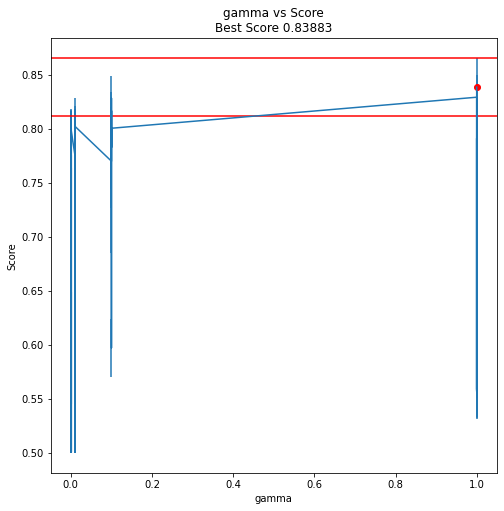

In [23]:
GridSearch_table_plot(random_estimator, "gamma", negative=False)

In [19]:
from sklearn import metrics
print(metrics.classification_report(y_test_resampled, pred))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      5453
           1       0.78      0.88      0.83      5453

    accuracy                           0.82     10906
   macro avg       0.82      0.82      0.82     10906
weighted avg       0.82      0.82      0.82     10906



## SGDClassifier

In [121]:
from sklearn.linear_model import SGDClassifier
sdg_clf = SGDClassifier(loss="log", penalty="l2", alpha = 0.001, learning_rate='optimal')
sdg_clf.fit(X_train_data_lr, y_train_resampled)
y_pred = sdg_clf.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test_resampled, smoothing(y_pred)))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled,  smoothing(y_pred)))

Accuracy: 0.6474600610303357

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.68      0.55      0.61      5571
           1       0.62      0.75      0.68      5571

    accuracy                           0.65     11142
   macro avg       0.65      0.65      0.64     11142
weighted avg       0.65      0.65      0.64     11142



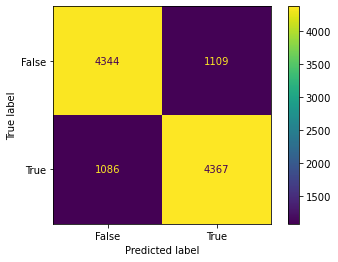

In [44]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [101]:
import pickle
with open('ML_data/models_ML/gl/ML_SDG_adapt.pkl','wb') as f:
    pickle.dump(sdg_clf,f)

In [24]:
# set search parameters
loss = ['hinge', 'log_loss', 'log', 'modified_huber', 'perceptron', 'squared_error']
penalty = ['l2','l1','elasticnet']
learning_rate = ['constant','optimal','invscaling']
alpha = [0.0001, 0.001, 0.01, 0.1]
random_grid = {
    'loss': loss,
    'penalty': penalty,
    'alpha': alpha,
    'learning_rate': learning_rate
}

In [25]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier() 
sgd_random = RandomizedSearchCV(estimator = sgd, random_state = 42,n_jobs = -1,param_distributions = random_grid,n_iter = 100, cv=3,verbose = 2)
sgd_random.fit(X_train_data_lr, y_train_resampled)
sgd_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'penalty': 'l2', 'loss': 'log', 'learning_rate': 'optimal', 'alpha': 0.0001}

In [26]:
sgd_random.best_params_

best_estimator = sgd_random.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(pred, y_test_resampled)

0.7700348432055749

In [28]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      5453
           1       0.76      0.79      0.77      5453

    accuracy                           0.77     10906
   macro avg       0.77      0.77      0.77     10906
weighted avg       0.77      0.77      0.77     10906



best parameters: {'penalty': 'l2', 'loss': 'log', 'learning_rate': 'optimal', 'alpha': 0.0001}
best score:      0.80068 (+/-0.00475)
{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_loss,param_learning_rate,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
52,0.095335,0.001885,0.001999,1.184119e-06,l2,log,optimal,0.0001,"{'penalty': 'l2', 'loss': 'log', 'learning_rat...",0.794283,0.802079,0.805673,0.800679,0.004754,1
73,0.191667,0.006650,0.002001,1.362676e-06,l1,modified_huber,optimal,0.0001,"{'penalty': 'l1', 'loss': 'modified_huber', 'l...",0.794197,0.801126,0.805933,0.800419,0.004818,2
23,0.123333,0.004190,0.002000,4.495664e-07,l1,log,optimal,0.0001,"{'penalty': 'l1', 'loss': 'log', 'learning_rat...",0.796968,0.797012,0.806799,0.800260,0.004624,3
86,0.105000,0.003741,0.001666,4.710332e-04,elasticnet,log,optimal,0.0001,"{'penalty': 'elasticnet', 'loss': 'log', 'lear...",0.791035,0.796838,0.806323,0.798066,0.006301,4
66,0.098999,0.008486,0.002336,4.730017e-04,l1,modified_huber,optimal,0.001,"{'penalty': 'l1', 'loss': 'modified_huber', 'l...",0.796319,0.791728,0.805110,0.797719,0.005552,5
56,0.115001,0.005716,0.002000,2.823245e-06,l1,hinge,optimal,0.0001,"{'penalty': 'l1', 'loss': 'hinge', 'learning_r...",0.782070,0.800303,0.807016,0.796463,0.010540,6
55,0.224665,0.042160,0.002334,4.709214e-04,elasticnet,modified_huber,optimal,0.0001,"{'penalty': 'elasticnet', 'loss': 'modified_hu...",0.795539,0.796882,0.796232,0.796218,0.000548,7
7,0.095007,0.005110,0.002326,4.769227e-04,l1,hinge,optimal,0.001,"{'penalty': 'l1', 'loss': 'hinge', 'learning_r...",0.791338,0.794933,0.802339,0.796203,0.004580,8
22,0.108333,0.003399,0.002002,1.520405e-06,l1,log,optimal,0.001,"{'penalty': 'l1', 'loss': 'log', 'learning_rat...",0.789563,0.794327,0.804331,0.796073,0.006154,9
81,0.082333,0.001247,0.002000,1.946680e-07,l1,log_loss,optimal,0.001,"{'penalty': 'l1', 'loss': 'log_loss', 'learnin...",0.789476,0.793547,0.802728,0.795250,0.005543,10


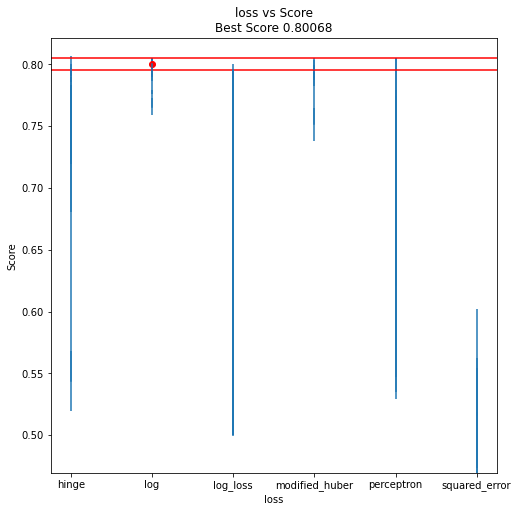

In [27]:
GridSearch_table_plot(sgd_random, "loss", negative=False)

## KNeighborsClassifier

In [93]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=13,weights="distance", metric="manhattan" )
#model = KNeighborsClassifier( )

# Train the model using the training sets
model.fit(X_train_data_lr,y_train_resampled)
y_pred = model.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test_resampled, smoothing(y_pred)))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, smoothing(y_pred)))

Accuracy: 0.8177285318559557

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      5415
           1       0.80      0.86      0.82      5415

    accuracy                           0.82     10830
   macro avg       0.82      0.82      0.82     10830
weighted avg       0.82      0.82      0.82     10830



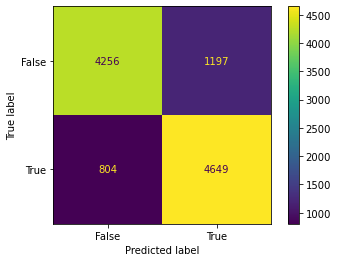

In [52]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled,smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [103]:
import pickle
with open('ML_data/models_ML/gl/ML_KNN_adapt.pkl','wb') as f:
    pickle.dump(model,f)

In [72]:
# set search parameters
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]   
weights = ['uniform','distance']
metric = ['euclidean','manhattan','chebyshev','minkowski'] 
random_grid = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric,
}

In [73]:
knn = KNeighborsClassifier() 
knn_random = RandomizedSearchCV(estimator = knn, random_state = 42,n_jobs = -1,param_distributions = random_grid,n_iter = 100, cv=3,verbose = 2)
knn_random.fit(X_train_data_lr, y_train_resampled)
knn_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'weights': 'distance', 'n_neighbors': 41, 'metric': 'manhattan'}

In [74]:
knn_random.best_params_

best_estimator = knn_random.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(pred, smoothing(y_test_resampled))

0.6116696588868941

best parameters: {'weights': 'distance', 'n_neighbors': 13, 'metric': 'manhattan'}
best score:      0.82570 (+/-0.00538)
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 13,
 'p': 2,
 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_metric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
36,0.381001,0.055898,3.275215,0.086927,distance,13,manhattan,"{'weights': 'distance', 'n_neighbors': 13, 'me...",0.818363,0.827588,0.831139,0.825697,0.005385,1
56,0.403334,0.128286,2.274876,0.251087,distance,23,chebyshev,"{'weights': 'distance', 'n_neighbors': 23, 'me...",0.819056,0.824643,0.830489,0.824729,0.004668,2
21,0.401181,0.040062,2.309964,0.347557,distance,15,euclidean,"{'weights': 'distance', 'n_neighbors': 15, 'me...",0.818796,0.825032,0.829623,0.824484,0.004437,3
76,0.389334,0.014974,2.220000,0.164952,distance,27,chebyshev,"{'weights': 'distance', 'n_neighbors': 27, 'me...",0.818233,0.822997,0.831226,0.824152,0.005367,4
0,0.333060,0.047547,1.496007,0.275016,distance,9,chebyshev,"{'weights': 'distance', 'n_neighbors': 9, 'met...",0.817367,0.826159,0.828887,0.824137,0.004915,5
51,0.649999,0.072125,2.631031,0.330303,distance,21,minkowski,"{'weights': 'distance', 'n_neighbors': 21, 'me...",0.818709,0.823777,0.829623,0.824036,0.004459,6
27,0.398170,0.069841,2.359667,0.121892,distance,25,chebyshev,"{'weights': 'distance', 'n_neighbors': 25, 'me...",0.818233,0.824080,0.829623,0.823979,0.004651,7
18,0.352333,0.034741,2.791140,0.275726,distance,31,chebyshev,"{'weights': 'distance', 'n_neighbors': 31, 'me...",0.817107,0.821958,0.830359,0.823141,0.005475,8
90,0.396667,0.036261,2.792706,0.200151,distance,33,chebyshev,"{'weights': 'distance', 'n_neighbors': 33, 'me...",0.817843,0.821265,0.829970,0.823026,0.005105,9
10,0.391000,0.095104,1.548333,0.210143,distance,9,euclidean,"{'weights': 'distance', 'n_neighbors': 9, 'met...",0.818233,0.823863,0.826938,0.823011,0.003605,10


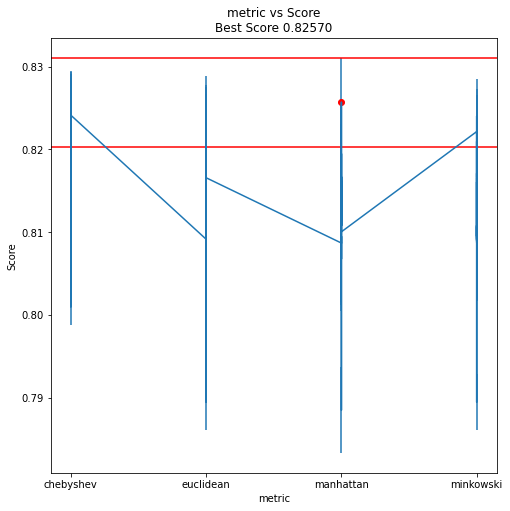

In [41]:
GridSearch_table_plot(knn_random, "metric", negative=False)

In [42]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      5453
           1       0.74      0.83      0.78      5453

    accuracy                           0.77     10906
   macro avg       0.78      0.77      0.77     10906
weighted avg       0.78      0.77      0.77     10906



## Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


regressor = RandomForestClassifier(n_estimators=40, random_state=0, max_depth=20, bootstrap=False)
regressor.fit(X_train_data_lr, y_train_resampled)
y_pred = regressor.predict(X_test_data_lr)
print("Accuracy:",metrics.accuracy_score(y_test_resampled, smoothing(y_pred)))

Accuracy: 0.8236380424746076


In [54]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, smoothing(y_pred)))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      5453
           1       0.80      0.91      0.85      5453

    accuracy                           0.84     10906
   macro avg       0.85      0.84      0.84     10906
weighted avg       0.85      0.84      0.84     10906



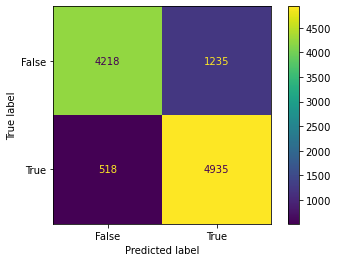

In [55]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [40]:
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 40, num = 40)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rf = RandomForestClassifier(random_state = 35)


In [42]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train_data_lr,y_train_resampled)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=35),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   random_state=35, verbose=2)

In [43]:
rf_random.best_params_

best_estimator = rf_random.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(pred, y_test_resampled)

0.7889235283330277

best parameters: {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}
best score:      0.85053 (+/-0.02800)
{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 35,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,8.702798,0.324727,0.091400,0.004409,40,2,1,auto,20,False,"{'n_estimators': 40, 'min_samples_split': 2, '...",0.816010,0.820702,0.856648,0.872311,0.886964,0.850527,0.028002,1
89,6.665798,0.349130,0.070000,0.001096,28,2,1,auto,40,False,"{'n_estimators': 28, 'min_samples_split': 2, '...",0.787643,0.819619,0.861989,0.871517,0.889707,0.846095,0.037198,2
91,8.841798,0.390735,0.092200,0.003429,39,2,3,auto,40,False,"{'n_estimators': 39, 'min_samples_split': 2, '...",0.799408,0.820052,0.855060,0.868702,0.884582,0.845561,0.031398,3
11,9.182798,0.455856,0.096400,0.004543,40,2,3,sqrt,40,False,"{'n_estimators': 40, 'min_samples_split': 2, '...",0.799264,0.819763,0.855349,0.868991,0.884366,0.845546,0.031494,4
69,9.173799,0.475697,0.096000,0.003899,40,6,3,sqrt,60,False,"{'n_estimators': 40, 'min_samples_split': 6, '...",0.797387,0.818320,0.855926,0.869135,0.885448,0.845243,0.032608,5
37,8.666620,0.432537,0.094400,0.004716,38,2,3,auto,100,False,"{'n_estimators': 38, 'min_samples_split': 2, '...",0.797604,0.818031,0.855637,0.869857,0.884293,0.845084,0.032400,6
73,8.516798,0.429439,0.089999,0.003899,38,2,4,auto,100,False,"{'n_estimators': 38, 'min_samples_split': 2, '...",0.805977,0.817237,0.853039,0.864804,0.884149,0.845041,0.029268,7
17,4.226598,0.190637,0.040600,0.001020,19,10,1,auto,20,False,"{'n_estimators': 19, 'min_samples_split': 10, ...",0.810524,0.814566,0.852173,0.866320,0.881190,0.844955,0.028037,8
59,7.962199,0.486853,0.084800,0.008305,35,6,4,auto,110,False,"{'n_estimators': 35, 'min_samples_split': 6, '...",0.804389,0.816659,0.853544,0.864804,0.885087,0.844897,0.030082,9
2,7.600999,0.341293,0.080201,0.002316,34,2,4,auto,100,False,"{'n_estimators': 34, 'min_samples_split': 2, '...",0.803956,0.817020,0.852894,0.864877,0.884582,0.844666,0.029970,10


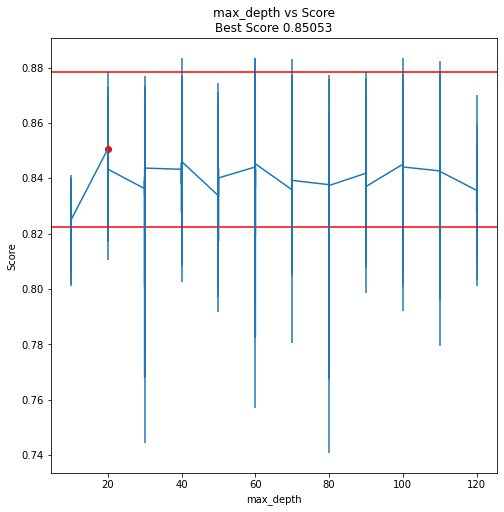

In [45]:
GridSearch_table_plot(rf_random, "max_depth", negative=False)

In [46]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled,pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.86      0.69      0.77      5453
           1       0.74      0.89      0.81      5453

    accuracy                           0.79     10906
   macro avg       0.80      0.79      0.79     10906
weighted avg       0.80      0.79      0.79     10906



In [105]:
import pickle
with open('ML_data/models_ML/gl/ML_RF_adapt.pkl','wb') as f:
    pickle.dump(regressor,f)

## Decision Tree

In [87]:
from sklearn import tree

dt_clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=20, min_samples_leaf= 100, max_features="sqrt")
dt_clf = dt_clf.fit(X_train_data_lr, y_train_resampled)
y_pred = dt_clf.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test_resampled, smoothing(y_pred)))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, smoothing(y_pred)))

Accuracy: 0.8211449676823638

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      5415
           1       0.80      0.86      0.83      5415

    accuracy                           0.82     10830
   macro avg       0.82      0.82      0.82     10830
weighted avg       0.82      0.82      0.82     10830



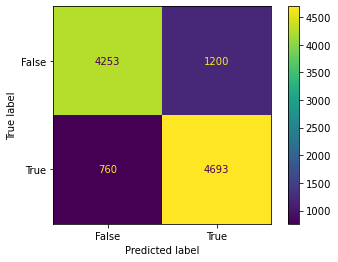

In [57]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [59]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
    'min_samples_leaf': [5, 10, 20, 50, 100, 150],
    'max_features' : ['auto', 'sqrt'],
    'criterion': ["gini", "entropy"]
}

In [60]:
from sklearn import tree

dt = DecisionTreeClassifier(random_state=42)

In [61]:
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = params,n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
dt_random.fit(X_train_data_lr,y_train_resampled)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [5, 10, 20, 50, 100,
                                                             150]},
                   random_state=35, verbose=2)

In [62]:
dt_random.best_params_

best_estimator = dt_random.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(pred, y_test_resampled)

0.7687511461580782

best parameters: {'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
best score:      0.80684 (+/-0.01852)
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.177799,0.012271,0.002200,0.000400,100,sqrt,20,gini,"{'min_samples_leaf': 100, 'max_features': 'sqr...",0.828208,0.780424,0.791252,0.809947,0.824383,0.806843,0.018519,1
4,0.219799,0.014837,0.002200,0.000400,20,auto,10,entropy,"{'min_samples_leaf': 20, 'max_features': 'auto...",0.813917,0.782734,0.792912,0.814133,0.827342,0.806208,0.016104,2
95,0.170599,0.006531,0.002800,0.000400,100,auto,80,gini,"{'min_samples_leaf': 100, 'max_features': 'aut...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3
26,0.161199,0.006014,0.002401,0.000489,100,sqrt,110,gini,"{'min_samples_leaf': 100, 'max_features': 'sqr...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3
90,0.163399,0.011413,0.002801,0.000400,100,auto,30,gini,"{'min_samples_leaf': 100, 'max_features': 'aut...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3
5,0.161599,0.007606,0.002400,0.000489,100,sqrt,80,gini,"{'min_samples_leaf': 100, 'max_features': 'sqr...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3
46,0.170799,0.014621,0.002200,0.000401,100,sqrt,90,gini,"{'min_samples_leaf': 100, 'max_features': 'sqr...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3
69,0.166399,0.008357,0.002600,0.000490,100,auto,120,gini,"{'min_samples_leaf': 100, 'max_features': 'aut...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3
74,0.188000,0.013520,0.002401,0.000491,100,sqrt,60,gini,"{'min_samples_leaf': 100, 'max_features': 'sqr...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3
36,0.169399,0.008685,0.002400,0.000490,100,auto,60,gini,"{'min_samples_leaf': 100, 'max_features': 'aut...",0.828208,0.780930,0.791252,0.806698,0.822506,0.805919,0.017956,3


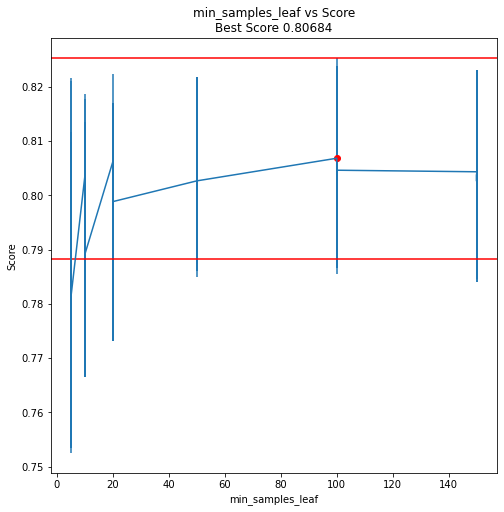

In [63]:
GridSearch_table_plot(dt_random, "min_samples_leaf", negative=False)

In [64]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled,pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      5453
           1       0.74      0.84      0.78      5453

    accuracy                           0.77     10906
   macro avg       0.77      0.77      0.77     10906
weighted avg       0.77      0.77      0.77     10906



In [107]:
import pickle
with open('ML_data/models_ML/gl/ML_DT_adapt.pkl','wb') as f:
    pickle.dump(dt_clf,f)

## Multi-layer perceptron (MLP)

In [149]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(50, 50, 50), random_state=1)
mlp_clf.fit(X_train_data_lr, y_train_resampled)
y_pred = mlp_clf.predict(X_test_data_lr)


In [59]:
print("Accuracy:", accuracy_score(y_test_resampled, smoothing(y_pred)))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, smoothing(y_pred)))

Accuracy: 0.8402714102328993

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5453
           1       0.83      0.86      0.84      5453

    accuracy                           0.84     10906
   macro avg       0.84      0.84      0.84     10906
weighted avg       0.84      0.84      0.84     10906



In [24]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)
mlp.fit(X_train_data_lr, y_train_resampled)


parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [26]:
random_estimator = RandomizedSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
random_estimator.fit(X_train_data_lr, y_train_resampled)

RandomizedSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.05],
                                        'hidden_layer_sizes': [(50, 50, 50),
                                                               (50, 100, 50),
                                                               (100,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['sgd', 'adam']})

In [27]:
random_estimator.best_params_

best_estimator = random_estimator.best_estimator_

best_estimator.fit(X_train_data_lr, y_train_resampled)

pred = best_estimator.predict(X_test_data_lr)

accuracy_score(pred, y_test_resampled)

0.7768200990280579

best parameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'relu'}
best score:      0.81405 (+/-0.00978)
{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 100,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_learning_rate,param_hidden_layer_sizes,param_alpha,param_activation,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,48.731500,1.501513,0.130000,0.026546,adam,constant,"(50, 50, 50)",0.0001,relu,"{'solver': 'adam', 'learning_rate': 'constant'...",0.800520,0.818320,0.823300,0.814046,0.009779,1
7,61.900035,0.670363,0.097667,0.027257,adam,adaptive,"(50, 100, 50)",0.0001,tanh,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.793071,0.815375,0.820442,0.809629,0.011890,2
9,25.035395,0.904005,0.034670,0.003679,adam,constant,"(100,)",0.0001,relu,"{'solver': 'adam', 'learning_rate': 'constant'...",0.796882,0.809874,0.822044,0.809600,0.010274,3
8,43.191642,0.563782,0.077999,0.015579,sgd,constant,"(50, 50, 50)",0.05,relu,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.798398,0.809961,0.817107,0.808489,0.007709,4
5,16.929457,3.948197,0.042000,0.004966,adam,adaptive,"(100,)",0.05,relu,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.800260,0.807709,0.817150,0.808373,0.006911,5
3,43.789255,0.366861,0.115332,0.008994,sgd,constant,"(50, 50, 50)",0.0001,relu,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.797098,0.810221,0.814508,0.807276,0.007406,6
4,44.887375,2.796695,0.117000,0.010802,adam,constant,"(50, 50, 50)",0.05,tanh,"{'solver': 'adam', 'learning_rate': 'constant'...",0.795842,0.804764,0.817497,0.806034,0.008886,7
6,58.067008,5.918505,0.101333,0.021453,adam,constant,"(50, 100, 50)",0.05,tanh,"{'solver': 'adam', 'learning_rate': 'constant'...",0.794716,0.807059,0.812560,0.804778,0.007461,8
2,61.338508,1.631915,0.181332,0.027620,sgd,adaptive,"(50, 100, 50)",0.0001,tanh,"{'solver': 'sgd', 'learning_rate': 'adaptive',...",0.795842,0.804504,0.810784,0.803710,0.006126,9
0,63.759160,1.189197,0.199332,0.018191,sgd,constant,"(50, 100, 50)",0.05,tanh,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.795539,0.802945,0.808142,0.802209,0.005171,10


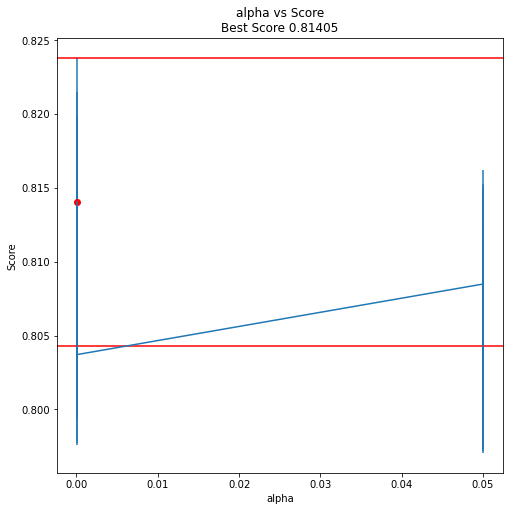

In [36]:
GridSearch_table_plot(random_estimator, "alpha", negative=False)

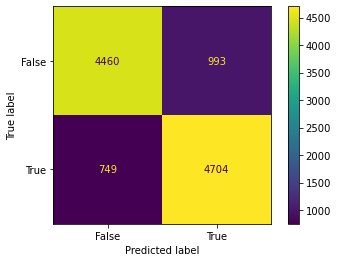

In [60]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled,smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [37]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.84      0.69      0.75      5453
           1       0.73      0.87      0.80      5453

    accuracy                           0.78     10906
   macro avg       0.79      0.78      0.78     10906
weighted avg       0.79      0.78      0.78     10906



In [109]:
import pickle
with open('ML_data/models_ML/gl/ML_MLP_adapt.pkl','wb') as f:
    pickle.dump(mlp_clf,f)

In [102]:
X_test_data_lr

array([[7.65650466e-02, 1.18499834e-01, 2.60204082e-01, 5.89048335e-02,
        6.00212653e-02, 3.74760519e-03],
       [2.11154228e-01, 1.46774751e-01, 3.16326531e-01, 4.23187934e-02,
        2.58373206e-02, 2.42090478e-03],
       [7.74570805e-01, 1.53439488e-01, 3.16326531e-01, 2.82531810e-02,
        2.58373206e-02, 1.33572968e-03],
       ...,
       [6.46170428e-02, 8.07991240e-02, 1.97448043e-01, 1.03676724e-02,
        8.96929816e-03, 1.47790437e-04],
       [3.10231094e-02, 1.99164476e-01, 3.70886432e-01, 2.46261510e-02,
        4.02940562e-02, 9.79794164e-04],
       [6.65951978e-02, 1.52948165e-01, 3.10685091e-01, 9.48558566e-03,
        1.58298145e-02, 1.84539086e-04]])

In [104]:
print(X_test_data_lr[:5])

[[0.07656505 0.11849983 0.26020408 0.05890483 0.06002127 0.00374761]
 [0.21115423 0.14677475 0.31632653 0.04231879 0.02583732 0.0024209 ]
 [0.77457081 0.15343949 0.31632653 0.02825318 0.02583732 0.00133573]
 [0.57521949 0.18065066 0.33673469 0.04113988 0.01541733 0.00308664]
 [0.10561727 0.16617025 0.33673469 0.04024554 0.01541733 0.00304811]]


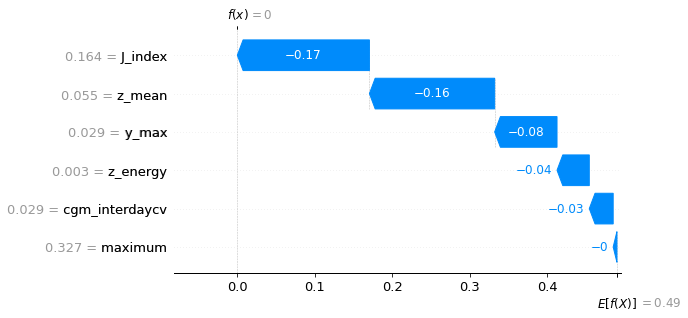

In [171]:
shap.plots.waterfall(shap_values[1456])

In [173]:
# Fits the explainer
explainer = shap.Explainer(svm_clf.predict, X_test_data_lr)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_data_lr[:400])

Exact explainer: 401it [1:12:37, 10.92s/it]                                                                            


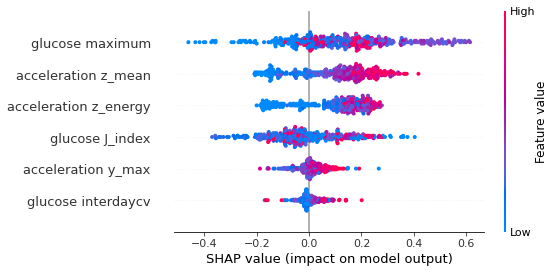

In [174]:
import shap

shap.summary_plot(shap_values, feature_names=["glucose interdaycv", "glucose J_index", "glucose maximum", "acceleration z_mean", "acceleration y_max", "acceleration z_energy"])
